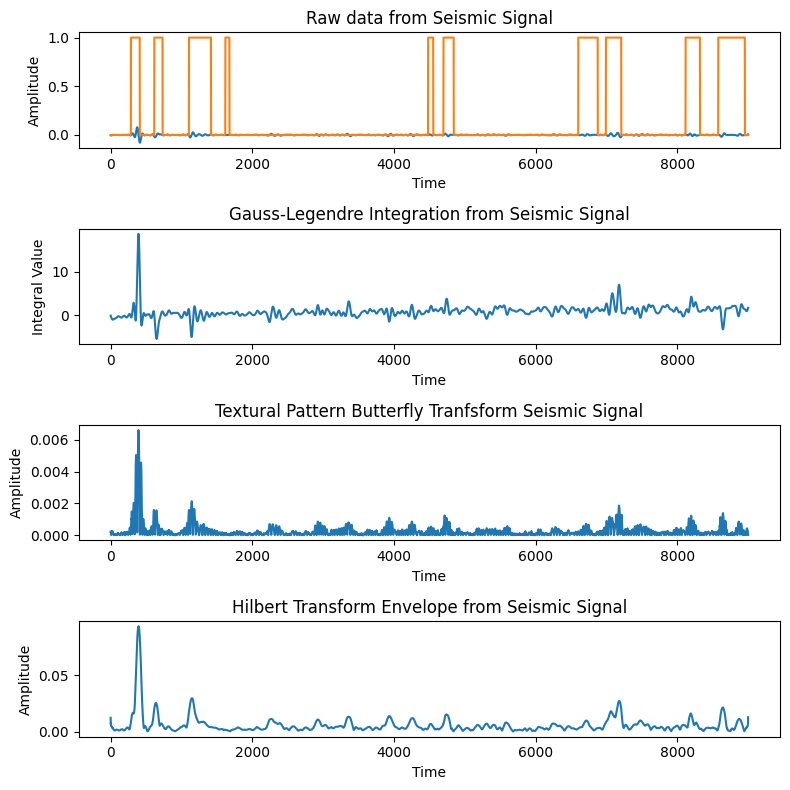

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pywt
import math
from scipy.signal import hilbert
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
class GaussLegendreQuadrature:
    def __init__(self, num_points):
        self.num_points = num_points
        gaussian_quad_data = {
            2: [(-math.sqrt(1/3), 1), (math.sqrt(1/3), 1)],
            3: [(-math.sqrt(3/5), 5/9), (0, 8/9), (math.sqrt(3/5), 5/9)],
            4: [(-math.sqrt(6/5), (5 + math.sqrt(5))/2), (-math.sqrt(6/5), (5 - math.sqrt(5))/2),
                 (math.sqrt(6/5), (5 - math.sqrt(5))/2), (math.sqrt(6/5), (5 + math.sqrt(5))/2)]
        }
        if num_points not in gaussian_quad_data:
            raise ValueError(f"Pre-computed data not available for {num_points} points. Please extend the gaussian_quad_data dictionary or use a different integration method.")
        self.points, self.weights = zip(*gaussian_quad_data[num_points])
    def integrate(self, function):
        result = 0
        for point, weight in zip(self.points, self.weights):
            result += weight * function(point)
        return result

def butterfly_pattern(data):
    t =np.arange(0,len(data))
    x = data * np.cos(t)
    y =  data * np.sin(t)
    return x, y

def hilbert_transform(data):
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope
data=np.array(pd.read_csv('D:\\sensor\\Microtremor Data\\filtered\\1.CSV',delimiter=';')['data'])[1000:10000]
label=np.array(pd.read_csv('D:\\sensor\\Microtremor Data\\label\\1.CSV',delimiter=';')['swave'])[1000:10000]
hilbert_envelope = hilbert_transform(data)
num_points = 4
gauss_legendre = GaussLegendreQuadrature(num_points)

x, y = butterfly_pattern(data)
textural_pattern = np.abs(np.gradient(data))

def function_to_integrate(x):
    return x

num_intervals = len(data)
x_vals = data
cumulative_sum_gauss = 0
cumulative_results_gauss = []

for i in range(num_intervals):
    x = x_vals[i]
    cumulative_sum_gauss += gauss_legendre.integrate(lambda x_val: function_to_integrate(x_val + x))
    cumulative_results_gauss.append(cumulative_sum_gauss)

plt.figure(figsize=(8, 8))
plt.subplot(4, 1, 1)
plt.plot(data)
plt.plot(label)
plt.title('Raw data from Seismic Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(4, 1, 2)
plt.plot(cumulative_results_gauss)  
plt.title('Gauss-Legendre Integration from Seismic Signal')
plt.xlabel('Time')
plt.ylabel('Integral Value')
plt.subplot(4, 1, 3)
plt.plot(textural_pattern)
plt.title('Textural Pattern Butterfly Tranfsform Seismic Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(4, 1, 4)
plt.plot(hilbert_envelope)
plt.title('Hilbert Transform Envelope from Seismic Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [2]:
class ConvBiLSTMAutoencoder(nn.Module):
    def __init__(self, num_heads=4):
        super(ConvBiLSTMAutoencoder, self).__init__()
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        self.encoder_lstm = nn.LSTM(input_size=8, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        # Multi-Head Attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads, batch_first=True)
        # Decoder
        self.decoder_lstm = nn.LSTM(input_size=128, hidden_size=8, num_layers=1, bidirectional=True, batch_first=True)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoding
        x = self.encoder_conv(x)
        x = x.permute(0, 2, 1)  # Reshape for LSTM (batch_size, seq_length, features)
        x, _ = self.encoder_lstm(x)
        # Multi-Head Attention
        attn_output, _ = self.multihead_attn(x, x, x)
        # Decoding
        x, _ = self.decoder_lstm(attn_output)
        x = x.permute(0, 2, 1)  # Reshape for ConvTranspose (batch_size, features, seq_length)
        x = self.decoder_conv(x)
        return x

model = ConvBiLSTMAutoencoder(num_heads=4)
print(model)



ConvBiLSTMAutoencoder(
  (encoder_conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_lstm): LSTM(8, 64, batch_first=True, bidirectional=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (decoder_lstm): LSTM(128, 8, batch_first=True, bidirectional=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose1d(16, 32, kernel_size=(2,), stride=(2,))
    (1): ReLU()
    (2): ConvTranspose1d(32, 1, kernel_size=(2,), stride=(2,))
    (3): Sigmoid()
  )
)


In [3]:
input = np.array(cumulative_results_gauss)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_i = scaler.fit_transform(input.reshape(-1, 1)).flatten()
input_signal = torch.tensor(data_i, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, len(data))

In [6]:
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=1)
    dice = (2. * intersection + smooth) / (pred.sum(dim=1) + target.sum(dim=1) + smooth)
    
    return 1 - dice.mean()
criterion = nn.MSELoss() #dice_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_training=[]
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    output = model(input_signal)
    loss = criterion(output, input_signal)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        loss_training.append(loss.item())
torch.save(model.state_dict(), 'conv_bilst_autoencoder_GLQ.pth')

print(loss_training)
plt.figure(figsize=(10,5))
plt.plot(loss_training,label='loss')
plt.legend()
plt.show()

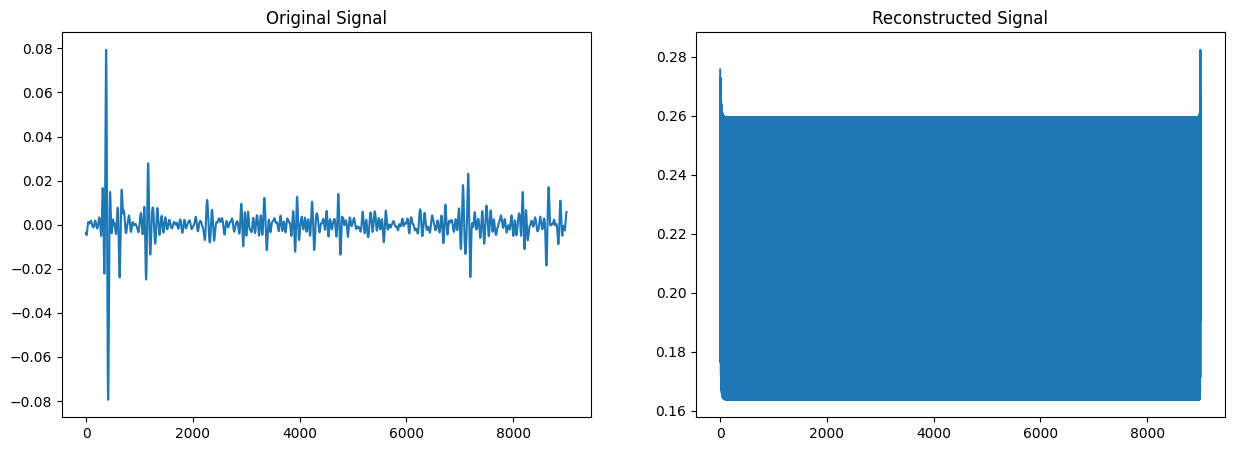

In [8]:
model.load_state_dict(torch.load('conv_bilst_autoencoder_GLQ.pth'))
model.eval()
with torch.no_grad():
    reconstructed_signal = model(input_signal).squeeze().numpy()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(data, label='Original Signal')
plt.title('Original Signal')
plt.subplot(1, 2, 2)
plt.plot(reconstructed_signal, label='Reconstructed Signal')
plt.title('Reconstructed Signal')
plt.show()


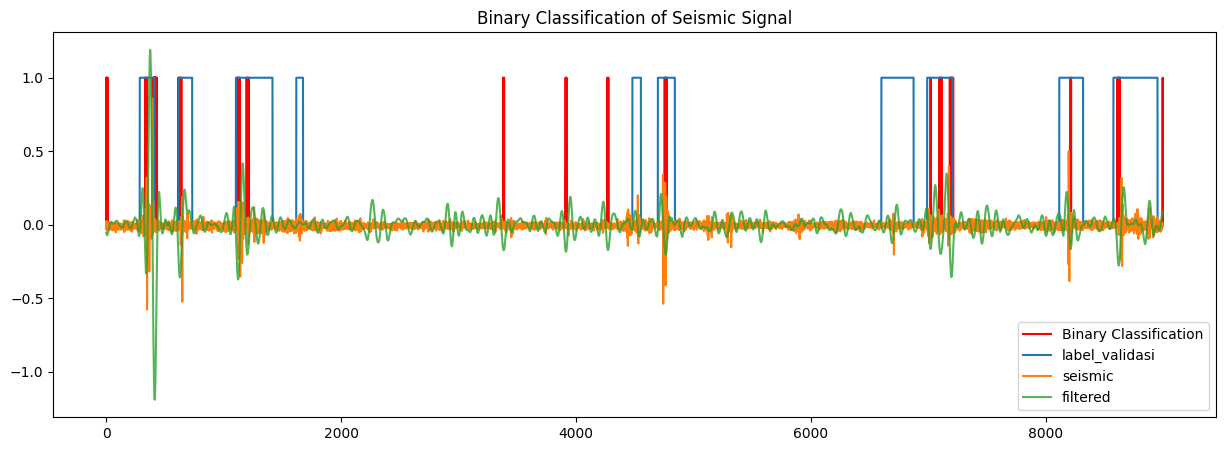

In [10]:
anomaly_scores = np.abs(data - reconstructed_signal)
threshold = 0.27
binary_classification = (anomaly_scores > threshold).astype(int)
microtremor=np.array(pd.read_csv('D:\\sensor\\Microtremor Data\\Microtremor Data\\1.CSV',delimiter=';')['CH3'])[1000:10000]
plt.figure(figsize=(15, 5))
plt.plot(binary_classification, label='Binary Classification', color='red')
plt.plot(label,label='label_validasi')
plt.plot(microtremor*20,label='seismic')
plt.plot(data*15,label='filtered',alpha=0.8)
plt.title('Binary Classification of Seismic Signal')
plt.legend()
plt.show()


Confusion Matrix:
[[7073   26]
 [1844   57]]
Recall: 0.0300
Accuracy: 0.7922


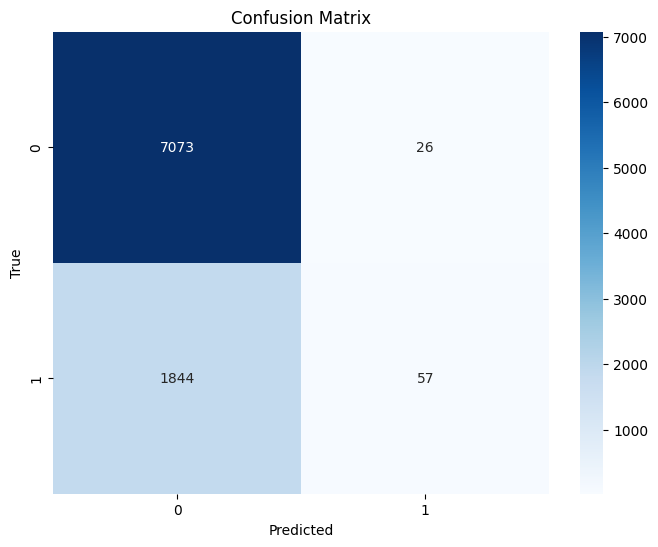

In [34]:
model.eval()
y_true = label
y_pred = binary_classification

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Calculate recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()